## requirements

In [78]:
%%bash
pip install pandas seaborn matplotlib statannotations numpy jupyterlab --quiet
pip show matplotlib seaborn statannotations | grep -E "^(Name|Version)"

Name: matplotlib
Version: 3.10.5
Name: seaborn
Version: 0.13.2
Name: statannotations
Version: 0.7.2


# Load data

In [91]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

plot_data = pd.read_csv("01_results_to_plot.csv")
plot_data.sample(5)

,Unnamed: 0,Model,Dataset,AUROC,Accuracy,Train time,Inference time,Trainable params,Shuffling
3596,46,BrainNetCNN,UK Biobank (Age-Sex) ICA,0.798632,0.156232,584.794051,0.000143,275275.0,NaN
6374,24,meanTransformer,ADNI ICA,0.615385,0.870000,54.829050,0.000302,6137098.0,NaN
7589,39,Glacier,ADNI ICA,0.503095,0.870000,26.107250,0.000625,868163.0,NaN
2064,14,BNT,ABIDE Schaefer 200 ROI,0.668207,0.680233,13.953551,0.000175,3980890.0,NaN
4551,1,meanMLP,ADNI ICA,0.766547,0.858586,2.954373,0.000042,9282.0,NaN


# Plot data

## Prepare data for plotting

In [92]:
models = [
    "meanMLP", # 0, time series models
    'LSTM',
    'Transformer',
    "MILC", 
    "DICE", 
    "BolT",
    "Glacier", # 6

    "BNT", # 7, FNC models
    "FBNetGen", 
    "BrainNetCNN", 
    "LR", # 10
]
ts_models = models[:7]
fnc_models = models[7:]

datasets = [
    "FBIRN ICA", # 0, ICA datasets
    "BSNIP ICA",
    "COBRE ICA",
    "ABIDE ICA",
    "OASIS ICA",
    "ADNI ICA",
    "HCP ICA", # 6

    "UK Biobank (Sex) ICA", # 7, 2 UKB dataset with different classification tasks
    "UK Biobank (Age-Sex) ICA", # 8

    "FBIRN Schaefer 200 ROI", # 9, ROI datasets
    "ABIDE Schaefer 200 ROI",
    "HCP Schaefer 200 ROI", # 11
]

rename_dict = { # used to rename dataset labels in the final plot for brevity
    "FBIRN ICA": "FBIRN",
    "BSNIP ICA": "BSNIP",
    "COBRE ICA": "COBRE",
    "ABIDE ICA": "ABIDE",
    "OASIS ICA": "OASIS",
    "ADNI ICA": "ADNI",
    "HCP ICA": "HCP",
    "UK Biobank (Sex) ICA": "UKB-S",
    "UK Biobank (Age-Sex) ICA": "UKB-SA",

    "FBIRN Schaefer 200 ROI": "FBIRN",
    "ABIDE Schaefer 200 ROI": "ABIDE",
    "HCP Schaefer 200 ROI": "HCP",

    "HCP ICA Time": "HCP",
}


# preparing ICA datasets
ica_datasets = datasets[:7]
data_ica = plot_data.query("Dataset in @ica_datasets") 
data_ica["Dataset"] = data_ica["Dataset"].replace(rename_dict) # Cut ICA suffixes for brevity
ica_datasets = [rename_dict[dataset] for dataset in ica_datasets]

# preparing UKB datasets. It's better to show them separately, otherwise they look too squished
ukb_s_datasets = datasets[7:8]
data_s_ukb = plot_data.query("Dataset in @ukb_s_datasets")
data_s_ukb["Dataset"] = data_s_ukb["Dataset"].replace(rename_dict) # Rename for brevity
ukb_s_datasets = [rename_dict[dataset] for dataset in ukb_s_datasets]

ukb_sa_datasets = datasets[8:9]
data_sa_ukb = plot_data.query("Dataset in @ukb_sa_datasets")
data_sa_ukb["Dataset"] = data_sa_ukb["Dataset"].replace(rename_dict) # Rename for brevity
ukb_sa_datasets = [rename_dict[dataset] for dataset in ukb_sa_datasets]

# preparing ROI datasets
roi_datasets = datasets[9:12]
data_roi = plot_data.query("Dataset in @roi_datasets") 
data_roi["Dataset"] = data_roi["Dataset"].replace(rename_dict) # Cut ROI suffixes for brevity
roi_datasets = [rename_dict[dataset] for dataset in roi_datasets]


hue_order = models # used to fix the order of models results per dataset in the plots

palette = { item: plt.cm.tab20(i) for i, item in enumerate(models)} # create a fixed mapping between model and color.
# used for consistency in plots; some models were not tested on certain datasets, so colors would shift otherwise

# Make plots

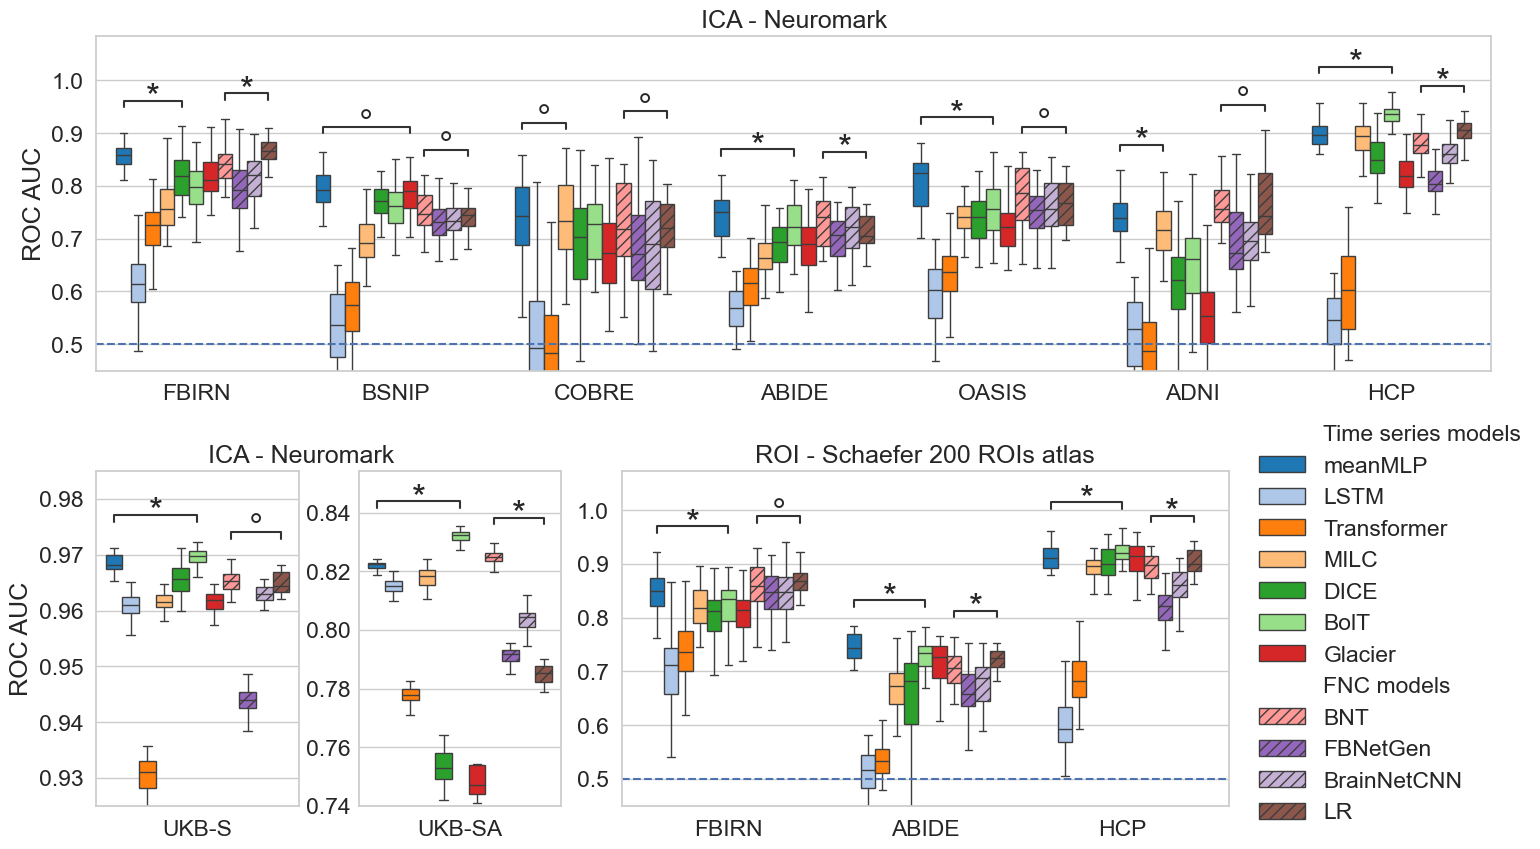

In [172]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
from matplotlib.legend_handler import HandlerBase
from statannotations.Annotator import Annotator

import numpy as np


# --- PLOTTING CONFIGURATION ---
sns.reset_orig() # reset style to default (in case it was modified before)
sns.set_theme(style="whitegrid", font_scale=1.5)    # these are seaborn handles for style, 
                                                    # feel free to experiment

sat = 1 # saturation, 0.75 seaborn default saturation for boxplots

pvalue_thresholds = [[0.05, "*"], [1, u"\u00B0"]] # p-value significance thresholds and symbols;
                                        # using ° (u"\u00B0") for non-significant, 
                                        # and * for significant. You can add more levels if needed.
pvalue_fontsize = 26 # fontsize for the statannotations; adjust to make bigger
pvalue_offset = -10 # vertical offset for the statannotations; adjust to move them up/down

fig = plt.figure(figsize=(18, 10)) # create a canvas and set its size (in inches)

gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.3)  # separate the canvas into 
                                                                # 2 rows, set spacing between rows

# --- Top Row: ICA Datasets without UKB ---
top_plot = plt.subplot(gs[0])

sns.boxplot(
    x="Dataset",            # x-axis: datasets
    order=ica_datasets,     # fix order of datasets
    y="AUROC",              # y-axis: AUROC scores
    hue="Model",            # for each dataset, show boxes for each model
    hue_order=hue_order,    # fix order of models per dataset
    data=data_ica,          # data to plot
    palette=palette,        # fix model colors
    showfliers=False,       # ignore outliers
    ax=top_plot,            # set the axis to plot on
    saturation=sat          # set saturation
)
top_plot.legend_.remove() # remove legend (will be placed later)
top_plot.axhline(y=0.5, linestyle='dashed') # add a coin-flip baseline
top_plot.set_xlabel(None) # Hide the label "Dataset". 
top_plot.set_yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]) # set y-ticks manually for beauty
top_plot.set_ylim(0.45, 1.05) # set y-limits manually
top_plot.set_ylabel("ROC AUC") # rename y-axis label, AUROC is a little unconventional
top_plot.set_title('ICA - Neuromark') # set title for the top plot
top_plot.set_xlim(-0.5, len(ica_datasets) - 0.5) # Manually set x-limits to reduce the side padding


# --- Bottom Row: Create Split Layout ---
bottom_row = gridspec.GridSpecFromSubplotSpec(1, 4,                         # create 4 subplots in the bottom row
                                              subplot_spec=gs[1],           # specify it's in the bottom row
                                              wspace=0.2,                   # set spacing between subplots
                                              width_ratios=[1, 1, 3, 1])    # set width ratios to [1, 1, 3, 1]
                                                                            # 1: UKB-S, 
                                                                            # 1: UKB-SA, 
                                                                            # 3: ROI (3 datasets), 
                                                                            # 1: Reserved for Legend
ukbs_plot = plt.subplot(bottom_row[0])      # UKB Sex
ukbsa_plot = plt.subplot(bottom_row[1])     # UKB Age-Sex
roi_plot = plt.subplot(bottom_row[2])       # ROI
legend_plot = plt.subplot(bottom_row[3])    # Reserved for the legend

# --- Plot UKB-S ---
sns.boxplot(
    x="Dataset", order=ukb_s_datasets, y="AUROC", hue="Model", hue_order=hue_order,
    data=data_s_ukb, palette=palette, showfliers=False, ax=ukbs_plot, saturation=sat
)
ukbs_plot.legend_.remove()
ukbs_plot.set_xlabel(None)
ukbs_plot.set_ylim(0.925, 0.985) # Tighter scale for UKB
ukbs_plot.set_ylabel("ROC AUC")

# --- Plot UKB-SA ---
sns.boxplot(
    x="Dataset", order=ukb_sa_datasets, y="AUROC", hue="Model", hue_order=hue_order,
    data=data_sa_ukb, palette=palette, showfliers=False, ax=ukbsa_plot, saturation=sat
)
ukbsa_plot.legend_.remove()
ukbsa_plot.set_xlabel(None)
ukbsa_plot.set_ylim(0.74, 0.845) # Tighter scale for UKB
ukbsa_plot.set_ylabel(None) # hide ylabel for tidyness
ukbsa_plot.tick_params(axis='y', pad=0) # reduce distance between axis and tick labels;
                                        # they were a little too close to other UKB plot

# Add ghost grid so that the UKB title appears centered above both UKB plots
ghostfig = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[1], width_ratios=[2, 3, 1])
ghost_ax = fig.add_subplot(ghostfig[0])
ghost_ax.axis('off') # hide the newly created plot (ghostify)
ghost_ax.set_title('ICA - Neuromark') # set title for the ghost plot (appreas centered above both UKB plots)

# --- Plot ROI ---
sns.boxplot(
    x="Dataset", order=roi_datasets, y="AUROC", hue="Model", hue_order=hue_order,
    data=data_roi, palette=palette, showfliers=False, ax=roi_plot, saturation=sat
)
roi_plot.legend_.remove()
roi_plot.axhline(y=0.5, linestyle='dashed') # add a coin-flip baseline
roi_plot.set_xlabel(None)
roi_plot.set_yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
roi_plot.set_ylim(0.45, 1.05)
roi_plot.set_ylabel(None) # hide ylabel for tidyness
roi_plot.set_title('ROI - Schaefer 200 ROIs atlas')

# # --- A SIMPLE WAY TO PLOT LEGEND ---
# legend_plot.axis('off') # hide axes
# top_plot.legend(bbox_to_anchor=legend_plot.get_position(), bbox_transform=fig.transFigure, loc='center', title='Models')

# --- CUSTOM LEGEND FUNCTION ---
# Applies hatching to FNC models in the legend as well

def prepare_handles(source_ax, palette, models_to_hatch, hatch_pattern="///", saturation=0.75):
    """
    1. Grabs handles from the source plot.
    2. Applies hatching to the specific models requested.
    3. Returns a dictionary mapping Model Name -> Handle.
    """
    handles, labels = source_ax.get_legend_handles_labels()
    handle_dict = dict(zip(labels, handles))
    
    # Pre-calculate hatch colors (desaturated); needed for matching the models below 
    target_rgbs = []
    for m in models_to_hatch:
        if m in palette:
            raw_rgba = mcolors.to_rgba(palette[m])
            desat_rgb = sns.desaturate(raw_rgba, saturation)
            target_rgbs.append(desat_rgb[:3])

    # Apply hatching to boxes
    for name, handle in handle_dict.items():
        if name in models_to_hatch and hasattr(handle, 'get_facecolor'):
             current_rgb = handle.get_facecolor()[:3]
             # Double check color match, or just trust the name if unique
             for target in target_rgbs:
                 if np.allclose(current_rgb, target, atol=0.01):
                     handle.set_hatch(hatch_pattern)
                     break
    
    return handle_dict

def place_legend(target_ax, handle_dict, groups, bbox_anchor=(-0.25, 1.0)):
    """
    Creates a single unified legend with 'Headers' for groups.
    """
    target_ax.axis('off')
    
    final_handles = []
    final_labels = []
    
    # Create a "ghost" handle for headers (invisible line)
    # We use a large empty space for the label or just bold text if LaTeX is supported
    def get_header_handle():
        return mlines.Line2D([], [], color='none', marker='None', linestyle='None')

    for title, model_names in groups.items():
        # 1. Add Header
        final_handles.append(get_header_handle())
        final_labels.append(title)
        
        # 2. Add Models
        for name in model_names:
            if name in handle_dict:
                final_handles.append(handle_dict[name])
                final_labels.append(name)
        

    # Create legend
    target_ax.legend(
        final_handles, final_labels, 
        loc='upper left', 
        bbox_to_anchor=bbox_anchor,
        frameon=False,
        labelspacing=0.5, # Adjust spacing
    )
    
all_handles_dict = prepare_handles(top_plot, palette, fnc_models, saturation=sat)
legend_structure = {
    "Time series models": ts_models,
    "FNC models": fnc_models
}
place_legend(legend_plot, all_handles_dict, legend_structure, bbox_anchor=(-0.25, 1.2))

# --- Apply hatching to FNC model boxes ---
def apply_hatching(target, palette, models, hatch_pattern="///", saturation=0.75):
    """
    Apply hatching to boxes. 
    target: Can be a matplotlib Axes object (plot) OR a list of patch handles (legend and other manual stuff).
    saturation: The saturation used in the plot (Seaborn default is 0.75).
    """
    # 1. Calculate the Target Colors (Desaturated)
    target_rgbs = []
    for m in models:
        if m in palette:
            raw_rgba = mcolors.to_rgba(palette[m])
            # Desaturate matches the default sns.boxplot behavior
            desat_rgb = sns.desaturate(raw_rgba, saturation)
            target_rgbs.append(desat_rgb[:3])

    # 2. Determine what we are iterating over
    if hasattr(target, 'patches'):
        # It's an Axes object (like top_plot)
        items = target.patches
    elif isinstance(target, list):
        # It's a list of handles (like fnc_h)
        items = target
    else:
        return

    # 3. Iterate and Hatch
    for patch in items:
        # Some legend handles might be lines (if not boxplot), check if it has facecolor
        if not hasattr(patch, 'get_facecolor'):
            continue
            
        current_rgb = patch.get_facecolor()[:3]
        
        # Check against targets
        is_fnc_model = False
        for target_color in target_rgbs:
            if np.allclose(current_rgb, target_color, atol=0.01):
                is_fnc_model = True
                break
        
        if is_fnc_model:
            patch.set_hatch(hatch_pattern)

# Apply the hatching
apply_hatching(top_plot, palette, fnc_models, saturation=sat)
apply_hatching(ukbs_plot, palette, fnc_models, saturation=sat)
apply_hatching(ukbsa_plot, palette, fnc_models, saturation=sat)
apply_hatching(roi_plot, palette, fnc_models, saturation=sat)

# --- Apply stat annotations ---
def get_dynamic_pairs(df, dataset_order, metric='AUROC'):
    """
    Dynamically finds the pairs to compare for each dataset:
    1. meanMLP vs Next Best TS Model
    2. LR vs Next Best FNC Model
    """
    pairs = []
    for dataset in dataset_order:
        d = df[df['Dataset'] == dataset]
        means = d.groupby('Model')[metric].mean()
        
        # Compare meanMLP vs Next Best TS
        if 'meanMLP' in means.index:
            other_ts = [m for m in ts_models if m in means.index and m != 'meanMLP']
            if other_ts:
                best_ts = means[other_ts].idxmax()
                pairs.append(((dataset, 'meanMLP'), (dataset, best_ts)))
        
        # Compare LR vs Next Best FNC
        if 'LR' in means.index:
            other_fnc = [m for m in fnc_models if m in means.index and m != 'LR']
            if other_fnc:
                best_fnc = means[other_fnc].idxmax()
                pairs.append(((dataset, 'LR'), (dataset, best_fnc)))
    return pairs

def add_stats(ax, data, pairs, hue_order, pvalue_thresholds, pvalue_size=20, pvalue_offset=1):
    """
    Runs stats and colors the symbols.
    Uses Y-position sorting to robustly match multiple brackets at the same X-tick.
    """
    if not pairs: 
        return

    annot = Annotator(ax, pairs, data=data, x="Dataset", y="AUROC", hue="Model", hue_order=hue_order)
    annot.configure(
        test='Mann-Whitney', 
        text_format='star', 
        loc='inside', 
        pvalue_thresholds=pvalue_thresholds, 
        verbose=False,
        fontsize=pvalue_size,
        text_offset=pvalue_offset
    )
    annot.apply_and_annotate()
            
# Annotate
pairs_ica = get_dynamic_pairs(data_ica, ica_datasets)
add_stats(top_plot, data_ica, pairs_ica, hue_order, pvalue_thresholds, pvalue_size=pvalue_fontsize, pvalue_offset=pvalue_offset)

pairs_s = get_dynamic_pairs(data_s_ukb, ukb_s_datasets)
add_stats(ukbs_plot, data_s_ukb, pairs_s, hue_order, pvalue_thresholds, pvalue_size=pvalue_fontsize, pvalue_offset=pvalue_offset)

pairs_sa = get_dynamic_pairs(data_sa_ukb, ukb_sa_datasets)
add_stats(ukbsa_plot, data_sa_ukb, pairs_sa, hue_order, pvalue_thresholds, pvalue_size=pvalue_fontsize, pvalue_offset=pvalue_offset)

pairs_roi = get_dynamic_pairs(data_roi, roi_datasets)
add_stats(roi_plot, data_roi, pairs_roi, hue_order, pvalue_thresholds, pvalue_size=pvalue_fontsize, pvalue_offset=pvalue_offset)

plt.tight_layout()
plt.savefig("01_results_plot.png", dpi=300, bbox_inches='tight')
plt.savefig("01_results_plot.svg", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.ticker as ticker
from statannot import add_stat_annotation


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

sns.reset_orig()
sns.set_theme(
    style="whitegrid", 
    font_scale = 1.5,
)

# Create a figure and a grid of subplots (2 rows, 1 column)
fig = plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.3)

# Create subplots for each subfigure
subfig11 = plt.subplot(gs[0])

# Divide the lower row into two subplots with different widths
# subgs2 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[1], width_ratios=[1, 1, 3, 2])
subgs2 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[1], width_ratios=[2, 2, 6, 2])
subfig12 = plt.subplot(subgs2[0])
subfig13 = plt.subplot(subgs2[1])
subfig2 = plt.subplot(subgs2[2])
subfig3 = plt.subplot(subgs2[3])

### add ghost figure for UKB results title
ghostsubgs2 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[1], width_ratios=[4, 6, 2])
ghost_ax = fig.add_subplot(ghostsubgs2[0])
ghost_ax.axis('off')
ghost_ax.set_title('ICA - Neuromark')
###### plot data

## row 1
boxplot_1 = sns.boxplot(
    x="Dataset", 
    order=ica_datasets,
    y="AUROC",
    hue="Model",
    hue_order=hue_order,
    data=data_1,
    palette=palette,
    showfliers = False,
    ax=subfig11,
)
subfig11.legend_.remove()
subfig11.axhline(y=0.5, linestyle='dashed')
subfig11.set_xlabel(None)
subfig11.set_yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
subfig11.set_ylim(0.45, 1.05)
subfig11.set_ylabel("ROC AUC")
subfig11.set_title('ICA - Neuromark')

## row 2
boxplot_2 = sns.boxplot(
    x="Dataset", 
    order=ukb_s_datasets,
    y="AUROC",
    hue="Model",
    hue_order=hue_order,
    data=data_s_ukb,
    palette=palette,
    showfliers = False,
    ax=subfig12,
)
subfig12.legend_.remove()
subfig12.axhline(y=0.5, linestyle='dashed')
subfig12.set_xlabel(None)
# subfig11.set_yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
subfig12.set_ylim(0.925, 0.975)
subfig12.set_ylabel("ROC AUC")


boxplot_3 = sns.boxplot(
    x="Dataset", 
    order=ukb_sa_datasets,
    y="AUROC",
    hue="Model",
    hue_order=hue_order,
    data=data_sa_ukb,
    palette=palette,
    showfliers = False,
    ax=subfig13,
)
subfig13.legend_.remove()
subfig13.axhline(y=0.5, linestyle='dashed')
subfig13.set_xlabel(None)
# subfig13.set_yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
subfig13.set_ylim(0.74, 0.845)
subfig13.set_ylabel(None)

boxplot_4 = sns.boxplot(
    x="Dataset", 
    order=roi_datasets,
    y="AUROC",
    hue="Model",
    hue_order=hue_order,
    data=data_2,
    palette=palette,
    showfliers = False,
    ax=subfig2,
)
subfig2.set_title('ROI - Schaefer 200 ROIs atlas')
subfig2.legend_.remove()
subfig2.axhline(y=0.5, linestyle='dashed')
subfig2.set_xlabel(None)
subfig2.set_yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
subfig2.set_ylim(0.45, 1.05)
subfig2.set_ylabel(None)

###### Add hatches

for i in range(14, 22):
    boxplot_1.patches[i].set_hatch("///")
for i, box in enumerate(boxplot_1.patches):
    if i > 20:
        if i % 11 == 9 or i % 11 == 10 or i % 11 == 7 or i % 11 == 8:
            box.set_hatch("///")

for i in range(14, 22):
    boxplot_2.patches[i].set_hatch("///")
for i, box in enumerate(boxplot_2.patches):
    if i > 20:
        if i % 11 == 9 or i % 11 == 10 or i % 11 == 7 or i % 11 == 8:
            box.set_hatch("///")

for i in range(14, 22):
    boxplot_3.patches[i].set_hatch("///")
for i, box in enumerate(boxplot_3.patches):
    if i > 20:
        if i % 11 == 9 or i % 11 == 10 or i % 11 == 7 or i % 11 == 8:
            box.set_hatch("///")

for i in range(14, 22):
    boxplot_4.patches[i].set_hatch("///")
for i, box in enumerate(boxplot_4.patches):
    if i > 20:
        if i % 11 == 9 or i % 11 == 10 or i % 11 == 7 or i % 11 == 8:
            box.set_hatch("///")

# Create a legend in subfigure 3 for the boxplots
subfig3.axis('off')  # Turn off axis for legend subplot
legend_handles, legend_labels = subfig11.get_legend_handles_labels()

ts_models = [
    "meanMLP", 
    'LSTM',
    'Transformer',
    "MILC", 
    "DICE", 
    "BolT",
    "Glacier"
]
fnc_models = [
    "BNT", 
    "FBNetGen", 
    "BrainNetCNN", 
    "LR"
]

ts_handles = [handle for label, handle in zip(legend_labels, legend_handles) if label in ts_models]
ts_labels = [label for label in legend_labels if label in ts_models]
fnc_handles = [handle for label, handle in zip(legend_labels, legend_handles) if label in fnc_models]
fnc_labels = [label for label in legend_labels if label in fnc_models]

# Create legends for each category and place them in subfig4
legend_ts = subfig3.legend(handles=ts_handles, labels=ts_labels, title='Time Series Models', loc='upper left')

# # Calculate the position for legend_fnc to the right of legend_ts
legend_ts_bbox = legend_ts.get_bbox_to_anchor().transformed(subfig3.transAxes.inverted())
legend_fnc = subfig3.legend(handles=fnc_handles, labels=fnc_labels, title='FNC Models', loc='upper left', bbox_to_anchor=(legend_ts_bbox.x0, legend_ts_bbox.y0+0.15))
# legend_fnc = subfig3.legend(handles=fnc_handles, labels=fnc_labels, title='FNC Models', loc='upper left')

# # Readd the TS legend box to subfig3
subfig3.add_artist(legend_ts)

plt.savefig(
    "01_results_plot_old.png",
    dpi=300,
    bbox_inches='tight',
)
plt.close()